In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger("cmdstanpy").disabled = True
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import requests


/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction

This challenge consists in identifying trends and insights in a sales dataset and forecasting weekly sales based on a time series.

Those were the requirements:
1. Predict the sales of each department in each store for the next year.
2. Propose recommended actions based on the insights obtained, prioritizing those with the greatest business impact.
3. Model the effects of discounts during holiday weeks.
4. Create an API that allows the store system to query, through an endpoint, the sales forecast for the next four weeks.


The solution implements two different types of models, one to predict the weekly sales for the next four weeks and one to predict the next year.

The decision to choose two different models was to explore different available models/libraries. Both would be capable of making predictions for 4 weeks and 1 year.


**Facebook Prophet** - next year prediction

**Regressor (XGBoost)** - four weeks prediction




## 1. Predict the sales of each department in each store for the next year.


## 1.1 Data exploration

Before training a model to predict the next year sales, lets take a dive into the available data:

The dataset consists of 3 csv files containing stores/departments weekly sales from 05/02/2010 to 01/11/2012.

The first step was joining this data to gather all the relevant information and saving it into a new dataset (combined_data.csv)

The code for joining the data can be found in the notebook data_processing.ipynb

In [4]:
#dataframe containing the joined data
df = pd.read_csv('../data/combined_data.csv')
df.head()


,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,day
0,2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,5
1,2010-02-05,29,5,15552.08,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
2,2010-02-05,29,6,3200.22,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
3,2010-02-05,29,7,10820.05,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
4,2010-02-05,29,8,20055.64,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5


### With the combined data it was possible to start visualizing the overall weekly sales trends over the years

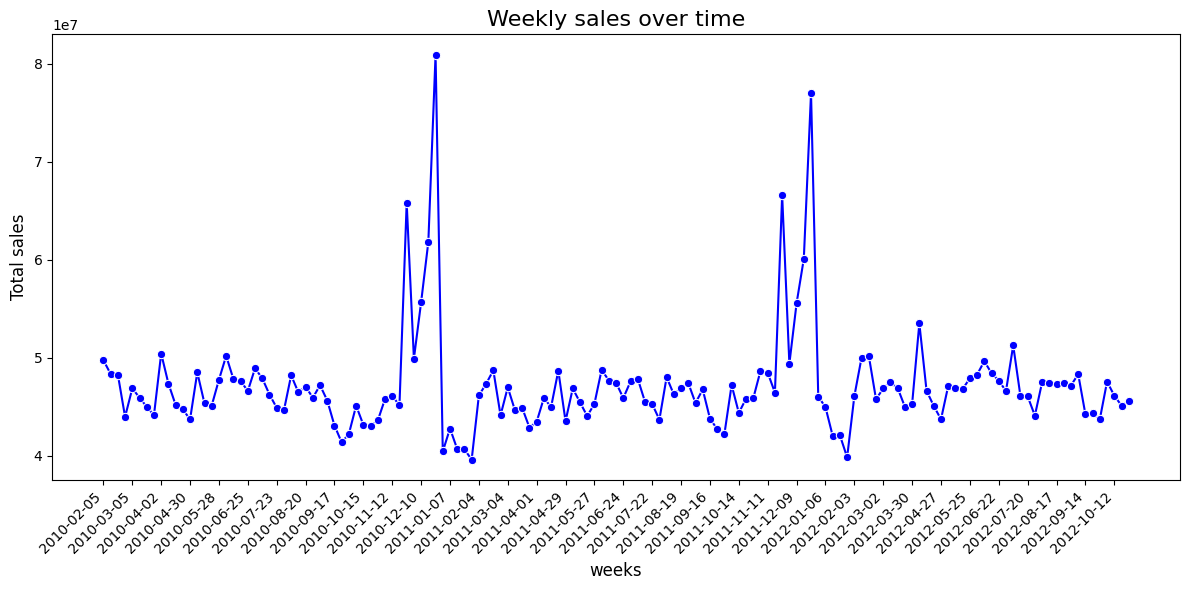

In [4]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x='Date', y='Weekly_Sales', marker='o', color='b')
plt.title('Weekly sales over time', fontsize=16)
plt.xlabel('weeks', fontsize=12)
plt.ylabel('Total sales', fontsize=12)
plt.xticks(weekly_sales.index[::4],  
           weekly_sales['Date'].iloc[::4],
           rotation=45,
           ha='right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

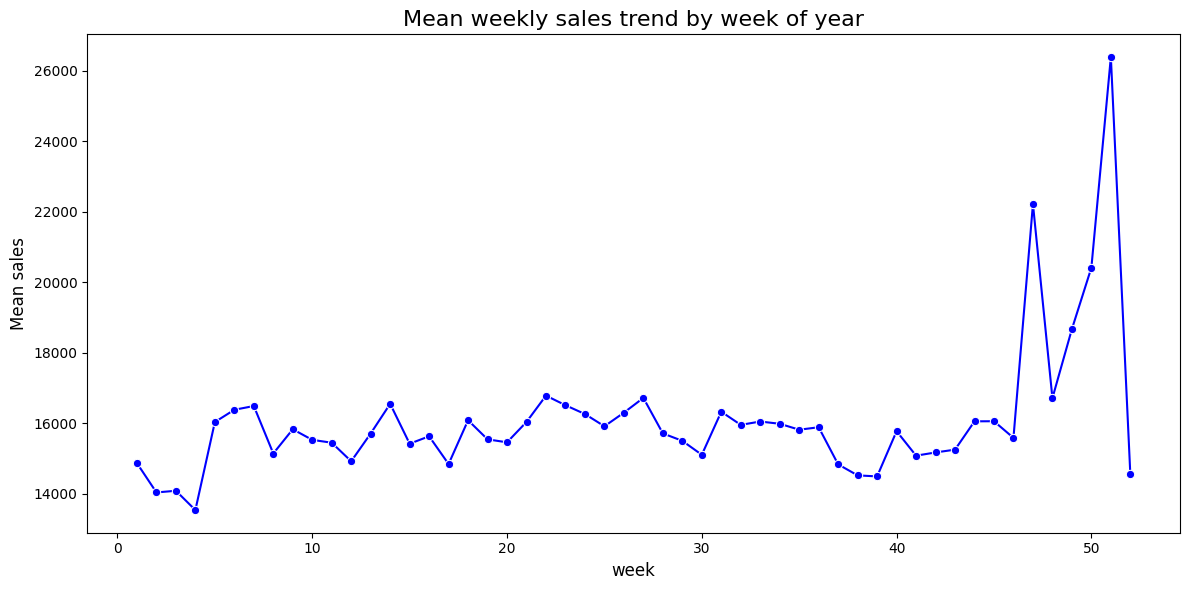

In [5]:
weekly_sales_by_week = df.groupby('week')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales_by_week, x='week', y='Weekly_Sales', marker='o', color='b')
plt.title('Mean weekly sales trend by week of year', fontsize=16)
plt.xlabel('week', fontsize=12)
plt.ylabel('Mean sales', fontsize=12)
plt.tight_layout()
plt.show()

## 1.2 Feature analysis

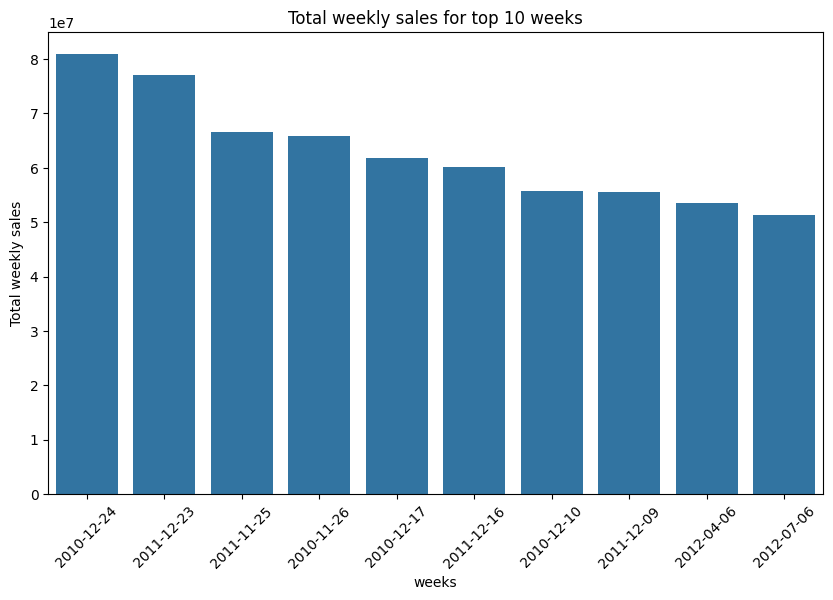

In [6]:
week_sales = df.groupby("Date")["Weekly_Sales"].sum()
top_5_total_sales = week_sales.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_total_sales.index, y=top_5_total_sales.values)
plt.xlabel("weeks")
plt.ylabel("Total weekly sales")
plt.title("Total weekly sales for top 10 weeks")
plt.xticks(rotation=45)
plt.show()

### The data shows that the highest sales peaks happens on the thanksgiving and christmas weeks, with a drop in the begging of the year, starting to recover on february with the super bowl week 

### The next step was to analyze the influence of external factors (temperature, fuel price, CPI, unemployment) into the weekly sales 

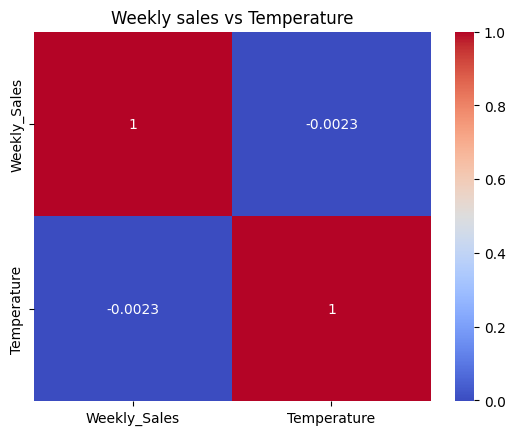

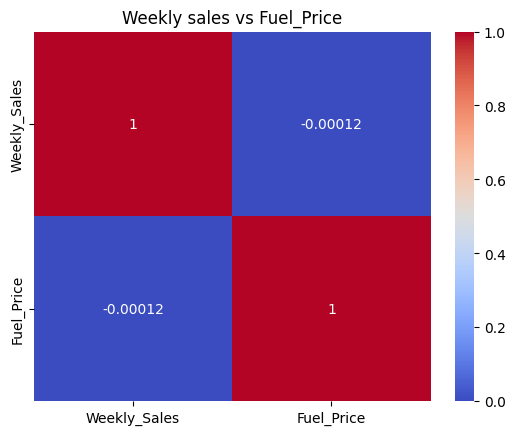

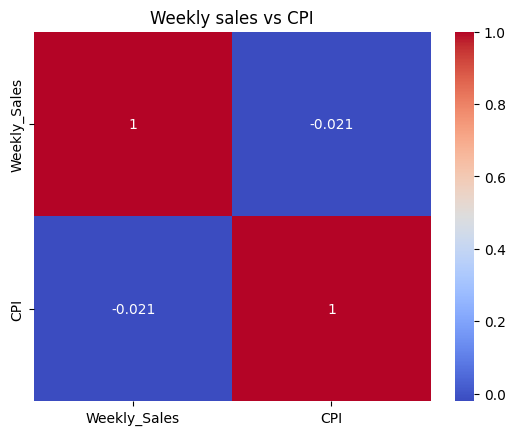

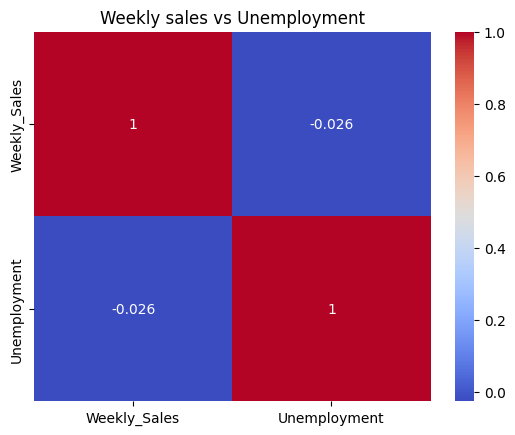

In [24]:

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for feature in features:
    correlation = df[['Weekly_Sales', feature]].corr()

    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title(f'Weekly sales vs {feature}')
    plt.show()


### The data shows that there is almost no correlation between enviroment factores and sales, with unemployment and CPI the only two with a correlation different to zero.

### MarkDowns also show almost no correlation with weekly sales

In [13]:
correlations = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']].corr()
markdown_sales_correlation = correlations['Weekly_Sales'].loc[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]
print(markdown_sales_correlation)

MarkDown1    0.085251
MarkDown2    0.024130
MarkDown3    0.060385
MarkDown4    0.045414
MarkDown5    0.090362
Name: Weekly_Sales, dtype: float64


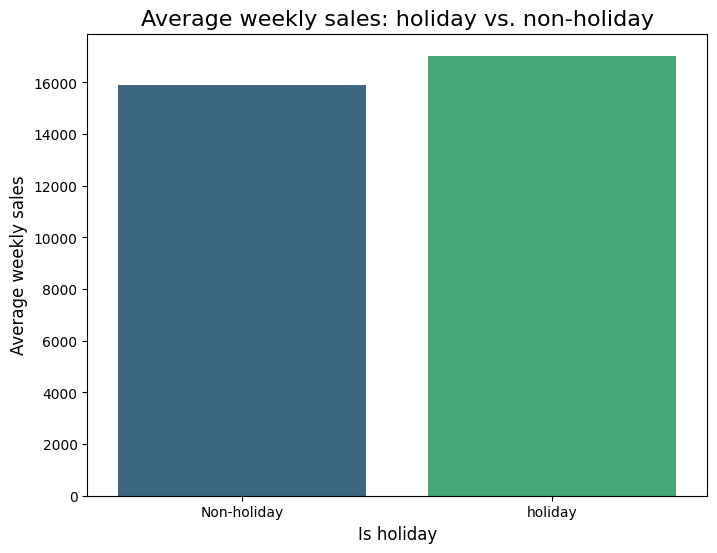

In [14]:
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette='viridis', hue=holiday_sales.index, legend=False)
plt.title('Average weekly sales: holiday vs. non-holiday', fontsize=16)
plt.xlabel('Is holiday', fontsize=12)
plt.ylabel('Average weekly sales', fontsize=12)
plt.xticks([0, 1], labels=['Non-holiday', 'holiday'], fontsize=10)
plt.show()

### Holidays, on the other hand, result in a 6.5% increase on the avarage weekly sales

### Finally we can analyze the weekly sales by store and department

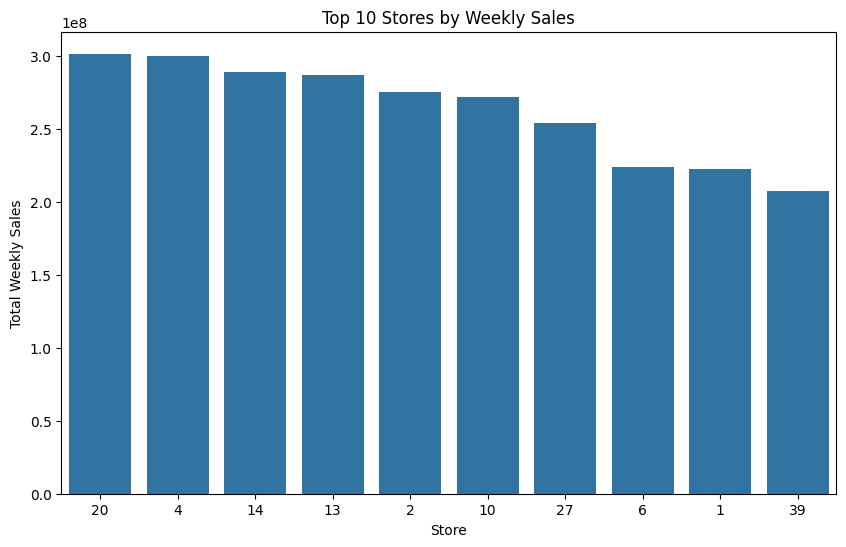

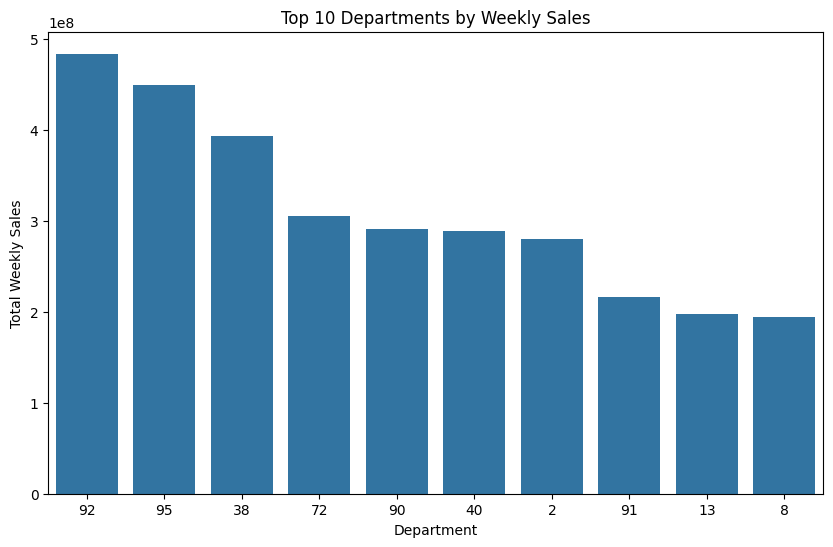

In [18]:
sales_by_store_dept = df.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().reset_index()
sales_by_store_dept = sales_by_store_dept.sort_values(by='Weekly_Sales', ascending=False)

top_stores = sales_by_store_dept.groupby('Store')['Weekly_Sales'].sum().nlargest(10).reset_index()
top_stores = top_stores.sort_values('Weekly_Sales', ascending=False)  # Changed to descending order
top_departments = sales_by_store_dept.groupby('Dept')['Weekly_Sales'].sum().nlargest(10).reset_index()
top_departments = top_departments.sort_values('Weekly_Sales', ascending=False)  # Changed to descending order
plt.figure(figsize=(10, 6))
sns.barplot(data=top_stores, x='Store', y='Weekly_Sales', order=top_stores['Store'])  # Added order parameter
plt.title('Top 10 Stores by Weekly Sales')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_departments, x='Dept', y='Weekly_Sales', order=top_departments['Dept'])  # Added order parameter
plt.title('Top 10 Departments by Weekly Sales')
plt.xlabel('Department')
plt.ylabel('Total Weekly Sales')
plt.show()

## 1.2 Model development

To predict the next year sales it was chosen Facebook's forecasting model [Prophet](https://github.com/facebook/prophet)

According to the documentation:
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.




### 1.2.1 Feature selection/engineering

The data exploration showed that enviroment features had no correlation with weekly sales, so they are being left out of the features trained in the model. 

All other features are being used to train the model, and one extra feature ('lag_weekly_sales') was created.

lag_weekly_sales is the weekly sales value for that store/department one year prior to the original date.

This feature was added to add one more seasonal information to the training data, and because it is a feature that can be retrieved when making a new prediction one year ahead.

### 1.2.2 Training

The complete training code can be found on the file **notebooks/prophet_training**

The holiday information was also included into the model both using the models holiday parameter and add_seasonality method. [Documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)

```
model = Prophet(holidays=holidays, holidays_prior_scale = 50, weekly_seasonality=True)
model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='IsHoliday')
model.add_country_holidays(country_name='US')
```
The dataset was splited into train/test and the model was fitted.

```
train, test = train_test_split(store_data, test_size=0.2, random_state=42)
```

With the adition of the lag feature, the data that could not have this information calculated (first 365 days) was removed. The adition of this feature improved the model performance greatly even with less data.






### 1.2.3 Results
The avarage weekly sales prediction for the testing dataset was really close to the true values
![prophet1](prophet_avg_true_pred.png)


The model testing show low error (low RMSE and MSE) and strong fit to the data (high R²):

R2: 0.9637257348752604

MSE : 19115006.856285512

RMSE: 4372.071231840295

Example of next year forecasting for store 5/dept 1:
![prophet2](forecast_5.png)


Model coeficcients:

The model coefs show that the features with highest impact in weekly sales are the features related to the date (month, week, day), followed by Store and Department. Markdowns in the other hand showed minor contribution to the forecast.
![prophet3](prophet_coef.png)


The cross validation shows that the MSE initially decreases with the increase of the amount of training data, but shortly after starts increasing again when the forecast horizon increases. 

This is a common patter of forecasting models that have more difficult predicting longer forecasting horizions.

The cross validation was done with the following parameters: 
```
df_cv = cross_validation(model, initial='365 days', period='15 days', horizon = '180 days')
df_p = performance_metrics(df_cv)
```

![prophet4](cross_validation_prophet.png)

The final result with one year prediction for all stores/depts can be found on the csv data/prophet_all_stores_prediction.csv

In [41]:
prophet_predictions = pd.read_csv('../data/prophet_all_stores_prediction.csv')
prophet_predictions.head(10)

,Unnamed: 0,date,Store,Dept,prediction
0,0,2011-07-01,5.0,1.0,3134.652961
1,1,2011-07-08,5.0,1.0,3892.868084
2,2,2011-07-15,5.0,1.0,3138.956257
3,3,2011-07-22,5.0,1.0,3031.440664
4,4,2011-07-29,5.0,1.0,2295.532599
5,5,2011-08-05,5.0,1.0,996.118147
6,6,2011-08-12,5.0,1.0,2355.292971
7,7,2011-08-19,5.0,1.0,2166.824871
8,8,2011-08-26,5.0,1.0,2729.927776
9,9,2011-08-26,5.0,1.0,1169.010871


## 2 Recommended actions
### Based on the analyzed data, those are my recommended actions:

### - **Optimize markdown strategies**: MarkDowns seems to have minor contributions to the overall weekly sales, improving MarkDown strategies specially during holiday weeks could improve the weekly sales during those weeks with the best performances.
### - **Holiday promotions**: weekly sales are considerably higher during holidays, creating markdown strategies to pre and post holiday weeks could improve weekly sales during those periods since people tend to already be more prone to buiyng during those dates.
### - **Focus on top performing stores**: Analyze what is being done in stores like 20,14 and 4 and reproduce their strategies to low performing stores
### - **Focus on top performing departments**: Analyze what is being done in departments like 92,95 and 38 and reproduce their strategies to low performing departments


## 3. Model the effects of discounts during holiday weeks.


To model the effects of discounts (Markdowns) during holiday weeks first the data was filtered to only select those dates.

Since MarkDown data is available only after nov 2011, the data that does not contain this information was also removed

In [21]:
holiday_data = df[df['IsHoliday']]
holiday_data = holiday_data.dropna()
features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Store', 'Dept']
X = holiday_data[features]
y = holiday_data['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_holiday = RandomForestRegressor(random_state=42)
model_holiday.fit(X_train, y_train)
y_pred = model_holiday.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



The results show that the combination of store/dept and markdowns information have a strong fit to the data (0.88 R²) and a low MAE and MSE

Mean Squared Error (MSE): 114032186.17
Mean Absolute Error (MAE): 5421.71
R-squared (R2): 0.88


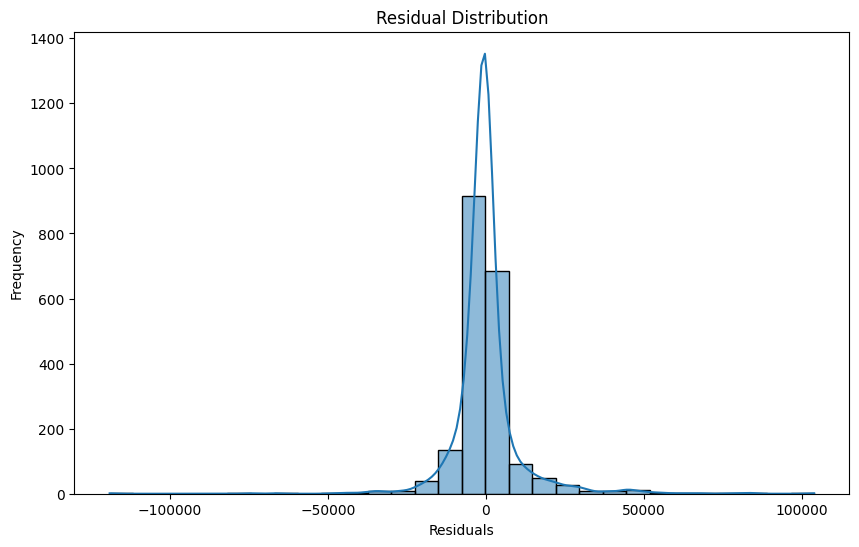

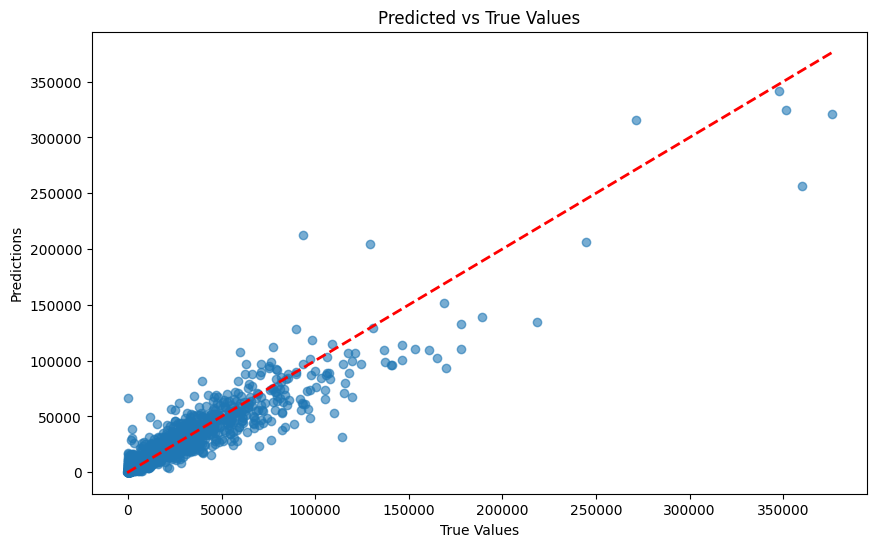

In [18]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


Looking at the feature importances it is possible to see that MarkDown3 is the only MarkDown that has a high impact on the weekly sales, and that department is the feature with the most importance to predict the target.

In [19]:
importance = pd.Series(model_holiday.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", importance)

Feature Importance:
 Dept         0.571774
MarkDown3    0.241685
Store        0.047979
MarkDown5    0.043049
MarkDown4    0.034112
MarkDown2    0.032993
MarkDown1    0.028408
dtype: float64


SHAP shows the same result, MarkDown3 is the Markdown with the highest impact, increasing its value increases the target (weekly sales) and decreasing it also decreases the target

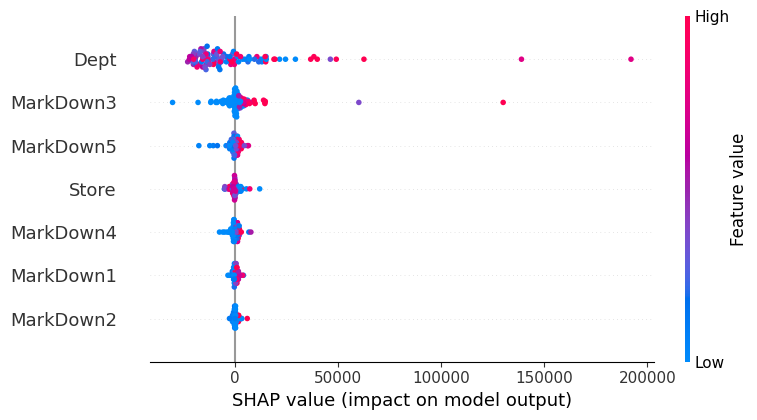

In [11]:
explainer_holiday = shap.TreeExplainer(model_holiday)
subset = X_test.sample(n=100, random_state=42) 
shap_values = explainer_holiday.shap_values(subset)
shap.summary_plot(shap_values, subset)
shap.force_plot(explainer_holiday.expected_value, shap_values[0], subset.iloc[0])

The correlation matrix also validates this conclusion with MarkDown3 having the highest correlation with weekly sales (0.15), followed by MarkDown5 (0.06) and the other MarkDowns with no correlation

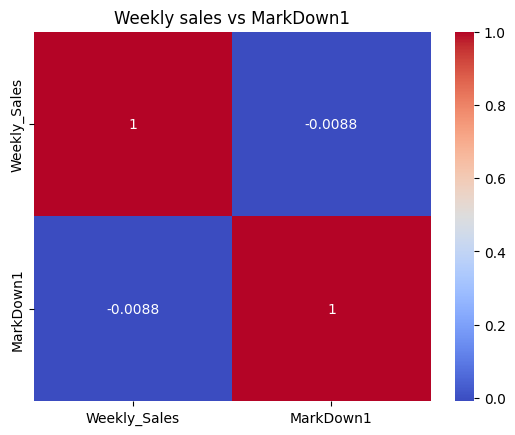

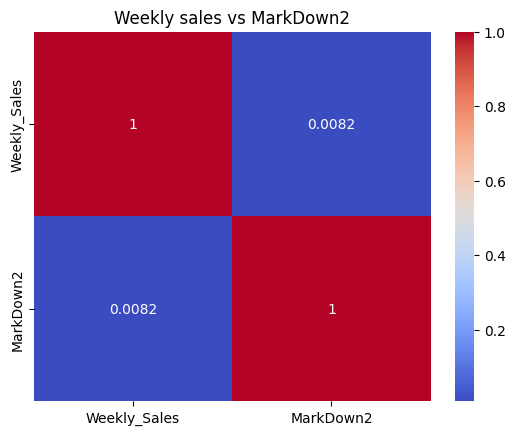

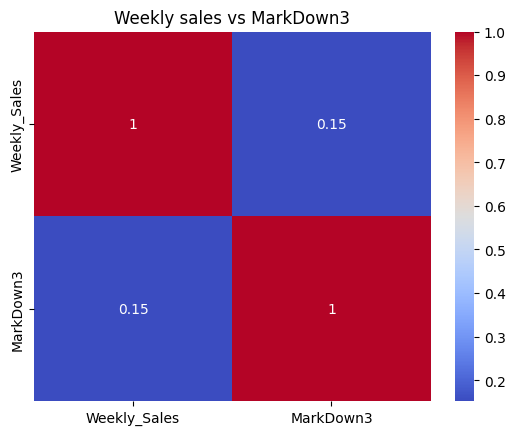

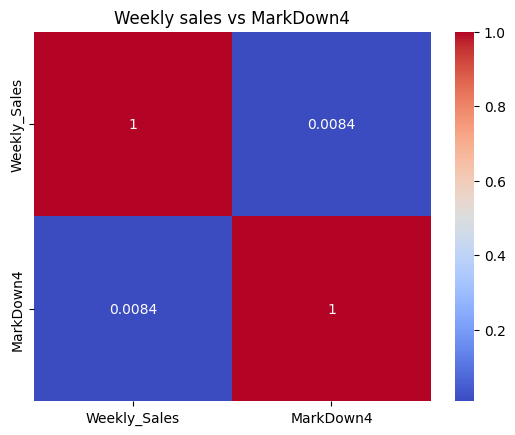

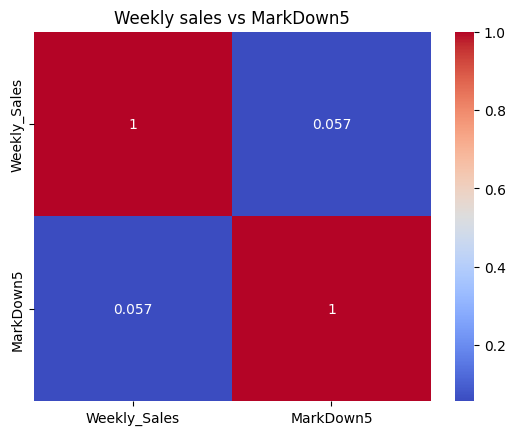

In [25]:
features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for feature in features:
    correlation = holiday_data[['Weekly_Sales', feature]].corr()

    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title(f'Weekly sales vs {feature}')
    plt.show()


## 4. Create an API that allows the store system to query, through an endpoint, the sales forecast for the next four weeks.


### 4.1 Model development

For this 4 weeks forecasting a different model was chosen. Instead of Facebooks Prophet model, it was used XGBoost (XGBRegressor) [XGBoost](https://xgboost.readthedocs.io/en/stable/)

The full training code can be found on the notebook **notebooks/4_weeks_model_training**

### 4.2 Feature Engineering
Similarly to what was done in the Prophet model, new features were created for this 4 weeks predictive model, but this time more lag features were created:

In [ ]:
#Function used to create the lag features on the data_processing.ipynb notebook
def prepare_forecasting_features_4_weeks(df):
    df = df.copy()
    shiftable_columns = ['Weekly_Sales', 'Temperature', 'MarkDown1', 'Fuel_Price',
                         'MarkDown2', 'MarkDown3', 'MarkDown4', 
                         'MarkDown5', 'CPI', 'Unemployment']
    dropable_columns = ['Temperature', 'MarkDown1', 'Fuel_Price',
                        'MarkDown2', 'MarkDown3', 'MarkDown4', 
                        'MarkDown5', 'CPI', 'Unemployment']
    
    lags = [4, 8, 16, 32]
    for lag in lags:
        for col in shiftable_columns:
            df[f'lag_{lag}_{col}'] = df.groupby(['Store', 'Dept'])[col].shift(lag)
    
    feature_df = df.drop(dropable_columns, axis=1)
    df_clean = feature_df.dropna(subset=['lag_32_Weekly_Sales'])
    return df_clean

## 4.3 Model training

The categorical features were encoded and the numerical scaled before training:

```
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
```





### 4.4 Results
The XGBoost Regressor model showed marginaly better results compared to the Prophet model, with low error (low RMSE and MSE) and strong fit to the data (high R²):

Mean Squared Error (MSE): 17788478.90

Mean Absolute Error (MAE): 1834.73

R-squared (R2): 0.97

Residuals:

![Residuals](residuals.png)


True values vs predictions for X_test (red = true, blue = prediction)

![Pred vs true1](predicted_vs_true.png)
![Pred vs true2](predicted_vs_true_test.png)



Prediction examples for specific store/depts:

![ex1](example1.png)
![ex2](example2.png)


Feature explainer:

Once again date was a strong predictive feature, but this time the lag features algo showed importance to predict the target, expecially the 4 weeks weekly sales lag.
![explained](feature_explained.png)


## 4.5 API and prediction endpoint

After training and saving the trained model, a class and methods for the model was created on /src/app/model_handler.py

The API was created using Flask on /src/app/app.py

The endpoint for making a 4 week prediction can be called by doing a POST request on the route /predict (must run ```python app.py``` first on /src/app)

In [28]:
#Input object consists on know data of the stores/depts you want to predict
data= {
            'store': 1,
            'dept': 1,
            'type':'A',
            'size': 1234,
            'date': '26/02/2011'
        }

url = 'http://127.0.0.1:5000/predict'

response = requests.post(url, json=data)

print(response.status_code)
print(response.json())


200
{'prediction': [[22099.158203125], [22099.158203125], [22099.158203125], [22099.158203125]]}


The prophet model created to predict the next year can also be used to predict other forecasts. It has a extra argument 'horizon' that receives a integer that represents the number of weeks you want to predict

In [39]:
#Input object consists on know data of the stores/depts you want to predict
data= {
            'store': 1,
            'dept': 1,
            'type':'A',
            'size': 1234,
            'date': '26/02/2011',
            'horizon' : 4 #number of weeks to predict
        }

url = 'http://127.0.0.1:5000/predict-prophet'

response = requests.post(url, json=data)

print(response.status_code)
print(response.json())


200
{'prediction': [[{'Dept': 1, 'Store': 1, 'date': 'Fri, 26 Oct 2012 00:00:00 GMT', 'weekly_sales': 20750.022766199636}, {'Dept': 1, 'Store': 1, 'date': 'Fri, 02 Nov 2012 00:00:00 GMT', 'weekly_sales': 23154.908208881694}, {'Dept': 1, 'Store': 1, 'date': 'Fri, 09 Nov 2012 00:00:00 GMT', 'weekly_sales': 23352.812801361637}, {'Dept': 1, 'Store': 1, 'date': 'Fri, 16 Nov 2012 00:00:00 GMT', 'weekly_sales': 31395.573925631863}]]}


## 5. Future Improvements 

- For the 4 weeks prediction problem, only one model was trained (XGBoost), although it is a really solid model and the performance was good, other models could be trained/tested for comparison
- For the 1 year prediction problem it could have been used the same strategy with the XGBoost model with better performance/interpretability, but Prophet is also a interesting model that I wanted to give a try
- The API was really simple only running locally, with only one endpoint for each model and no authentication methods, it served what had been asked but it could be improved in many ways if necessary
- Documenting the classes and methods would make it easier for others to understand/improve the code
